In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees

# Load Model

In [2]:
corr = 0.25
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze")

epoch=34-val_loss=0.174876.ckpt


In [3]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [4]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_1765320/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [5]:
n_eval_envs = 150

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


# Helper methods

In [6]:
def run_model(traj, model, state_features, seq_length, zero_reward=False):
    hidden_states = [[] for _ in range(model.n_layer)]
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        if zero_reward:
            batch['context_rewards'] *= 0
        with torch.no_grad():
            out = model(batch)
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(
                _hidden_states[i_layer].detach().cpu().numpy().squeeze()[-1])
    return hidden_states

# Collect representations

In [7]:
envs = []
layers = []
is_reward = []
hidden_states = [[] for _ in range(model.n_layer)]
seq_length = 1000

for i_eval, traj in enumerate(eval_trajs):
    env_config = {
        'max_layers': 7,
        'horizon': 1600,
        'branching_prob': 1.0,
        'node_encoding_corr': corr,
        'state_dim': state_dim,
        'initialization_seed': np.array(traj['initialization_seed']).item()
    }
    env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
    
    state_features = []
    state_features = list(env.node_map.keys())
    for state_feature in state_features:
        layers.append(env.node_map[state_feature].layer)
    reward_idx = np.argwhere([np.all(s == env.goal) for s in state_features]).item() 
    _is_reward = [False if i != reward_idx else True for i in range(len(state_features))]
    _hidden_states = run_model(traj, model, state_features, seq_length)
    envs.extend([i_eval] * len(state_features))
    is_reward.extend(_is_reward)
    for i_layer in range(model.n_layer):
        hidden_states[i_layer].extend(_hidden_states[i_layer])
    # Clear GPU memory
    del _hidden_states
    torch.cuda.empty_cache()


`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [8]:
def make_pca_plots(
    layers, is_reward, envs, hidden_states,
    dims=[0,1], figname=None):

    n_layers = len(hidden_states)
    fig, axs = plt.subplots(1, n_layers, figsize=(2.5, 0.9))
    
    # Randomly plot just a few environments
    envs = np.array(envs)
    np.random.seed(0)
    chosen_envs = np.random.choice(np.unique(envs), size=10)
    np.random.seed()
    env_mask = np.isin(envs, chosen_envs)
    is_reward = np.logical_and(is_reward, env_mask)
    not_reward = np.logical_not(is_reward)
    not_reward = np.logical_and(not_reward, env_mask)

    for ax, layer_hidden_states in zip(axs, hidden_states):
        data = np.array(layer_hidden_states)
        pca = PCA(n_components=10)
        data_pca = pca.fit_transform(data)
        data_pca = data_pca / np.abs(data_pca).max(axis=0)
        layers = np.array(layers)
        is_reward = np.array(is_reward)
        not_reward = np.logical_not(is_reward)
        # Plot the points
        ax.scatter(
            data_pca[not_reward, dims[0]],
            data_pca[not_reward, dims[1]],
            c=layers[not_reward],
            cmap='plasma', s=1, linewidth=0,
            alpha=0.3)
        ax.scatter(
            data_pca[is_reward, dims[0]],
            data_pca[is_reward, dims[1]],
            c='red', marker='*', s=5,
            alpha=0.4)
        ax.set_aspect('equal', 'box')
        ax.set_box_aspect(1)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(True)
    plt.tight_layout(pad=0.2, w_pad=0.5)
    if figname is not None:
        plt.savefig('figs/' + figname + '.png', transparent=True, dpi=300)
        plt.savefig('figs/' + figname + '.pdf', transparent=True, dpi=300)
    plt.show()

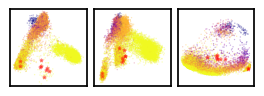

In [9]:
make_pca_plots(layers, is_reward, envs, hidden_states, figname='4e')